# Exercise IV: Function Approximation
>You will use function approximation to device controllers for the mountain car and/or cart pole problems in Assignment IV.

>Rather than code a function approximation class (straightforward but outside of the scope of our course), you'll use a library, TensorFlow, for this.

>There are two front ends for TensorFlow that make it easier to construct, debug, etc., neural networks (general nonlinear function approximation structures): Keras (keras.io) and TfLearn (tflearn.org).

>Consult the documentation for these two (either, your choice) and learn how to:

>* Construct a neural network with several layers
>* Obtain the gradient of the neural network with respect to its parameters
>* Train the neural network by stochastic gradient descent using a loop that you construct and in which you update the weights as per the gradient and the error (you will use this in A-IV)

>Submit, via pdf, the results of your investigation. Graded for completion; this is an opportunity for you to ask questions in case you are stuck.

>Consult Files/stochastic_gradient_descent_example.py for one example to help you get started.



In [8]:
import gym
import numpy as np
from collections import deque
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense

#from keras.optimizers import Adam

##Carte Pole

In [5]:
#Set up the environment
env = gym.make("CartPole-v0")
env.reset()


for i in range(50000):
  action = env.action_space.sample()
  print("step i",i,"action=",action)
  obs, reward, done, info = env.step(action)
  print("obs=",obs,"reward=",reward,"done=",done)

  if done:
    break
    
env.close()
print("Iterations that were run:",i)

step i 0 action= 0
obs= [-0.02640279 -0.20614888  0.0288152   0.26124097] reward= 1.0 done= False
step i 1 action= 1
obs= [-0.03052577 -0.01144986  0.03404002 -0.02221583] reward= 1.0 done= False
step i 2 action= 1
obs= [-0.03075477  0.18316781  0.0335957  -0.30396738] reward= 1.0 done= False
step i 3 action= 0
obs= [-0.02709141 -0.01241642  0.02751636 -0.00088131] reward= 1.0 done= False
step i 4 action= 0
obs= [-0.02733974 -0.20792196  0.02749873  0.30035479] reward= 1.0 done= False
step i 5 action= 1
obs= [-0.03149818 -0.01320254  0.03350582  0.01646968] reward= 1.0 done= False
step i 6 action= 0
obs= [-0.03176223 -0.20878858  0.03383522  0.31953296] reward= 1.0 done= False
step i 7 action= 1
obs= [-0.035938   -0.01416444  0.04022588  0.03770948] reward= 1.0 done= False
step i 8 action= 0
obs= [-0.03622129 -0.20983945  0.04098007  0.34280779] reward= 1.0 done= False
step i 9 action= 0
obs= [-0.04041808 -0.40551973  0.04783622  0.64812654] reward= 1.0 done= False
step i 10 action= 0


##Training: Nerual Network

In [ ]:
class NeuralNetwork():
    def __init__(self, state_dim, action_size):
        self.state_hist = np.zeros((self.state_dim, *action_size), dtype = np.float32)
        self.action_hist = np.zeros(self.state_dim, dtype = np.int32)
        self.new_state_hist = np.zeros((self.state_dim, *action_size), dtype = np.float32)
        self.reward_hist = np.zeros(self.state_dim, dtype = np.float32)
        self.done_hist = np.zeros(self.state_dim, dtype=np.uint8)
    
    def update_values(self,):
        




       
       


        #self.state_in = tf.placeholder(tf.float32, shape=[None, *state_dim])
        #self.action_in = tf.placeholder(tf.int32, shape=[None])
        self.q_target_in = tf.placeholder(tf.float32, shape=[None])
        action_one_hot = tf.one_hot(self.action_in, depth=action_size)
        
        #self.hidden1 = tf.layers.dense(self.state_in, 100, activation=tf.nn.relu)
        #self.q_state = tf.layers.dense(self.hidden1, action_size, activation=None)
        #self.q_state_action = tf.reduce_sum(tf.multiply(self.q_state, action_one_hot), axis=1)
        
        #self.loss = tf.reduce_mean(tf.square(self.q_state_action - self.q_target_in))
        #self.optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.loss)
        
    def update_model(self, session, state, action, q_target):
        feed = {self.state_in: state, self.action_in: action, self.q_target_in: q_target}
        session.run(self.optimizer, feed_dict=feed)
        
    def get_q_state(self, session, state):
        q_state = session.run(self.q_state, feed_dict={self.state_in: state})
        return q_state

In [ ]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape):
        self.mem_size = max_size
        self.mem_cntr = 0

        self.state_memory = np.zeros((self.mem_size, *input_shape),dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.uint8)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

In [7]:
def QNetwork(input_dims, action_size):
    model = Sequential()
    model.add(Dense(32,input_shape=(*input_dims,), activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(action_size, activation="linear"))
    model.compile(loss="mse", optimizer=Adam(lr=alpha))
    return model

In [9]:
class ReplayBuffer():
    def __init__(self, max_len):
        self.buffer = deque(max_len = max_len)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        sample_size = min(len(self.buffer), batch_size)
        samples = random.choices(self.buffer, k=sample_size)
        return map(list, zip(*samples))

In [ ]:
class Agent():
    def __init__(self, env):
        self.state_dim = env.observation_space.shape
        self.action_size = env.action_space.n
        self.q_network = QNetwork(self.state_dim, self.action_size)
        self.replay_buffer = ReplayBuffer(maxlen=10000)
        self.gamma = 0.97
        self.eps = 1.0
        
        
    def get_action(self, state):
        q_state = self.q_network.get_q_state(self.sess, [state])
        action_greedy = np.argmax(q_state)
        action_random = np.random.randint(self.action_size)
        action = action_random if random.random() < self.eps else action_greedy
        return action
    
    def train(self, state, action, next_state, reward, done):
        self.replay_buffer.add((state, action, next_state, reward, done))
        states, actions, next_states, rewards, dones = self.replay_buffer.sample(50)
        q_next_states = self.q_network.get_q_state(self.sess, next_states)
        q_next_states[dones] = np.zeros([self.action_size])
        q_targets = rewards + self.gamma * np.max(q_next_states, axis=1)
        self.q_network.update_model(self.sess, states, actions, q_targets)
        
        if done: self.eps = max(0.1, 0.99*self.eps)
    
    def __del__(self):
        self.sess.close()

In [ ]:
class Agent(object):
    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size, replace,
                 input_dims, eps_dec=0.996,  eps_min=0.01,
                 mem_size=1000000, q_eval_fname='q_eval.h5',
                 q_target_fname='q_next.h5'):
        self.action_space = [i for i in range(n_actions)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = eps_dec
        self.eps_min = eps_min
        self.batch_size = batch_size
        self.replace = replace
        self.q_target_model_file = q_target_fname
        self.q_eval_model_file = q_eval_fname
        self.learn_step = 0
        self.memory = ReplayBuffer(mem_size, input_dims)
        self.q_eval = build_dqn(alpha, n_actions, input_dims, 512)
        self.q_next = build_dqn(alpha, n_actions, input_dims, 512)

    def replace_target_network(self):
        if self.replace is not None and self.learn_step % self.replace == 0:
            self.q_next.set_weights(self.q_eval.get_weights())

    def store_transition(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, observation):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state = np.array([observation], copy=False, dtype=np.float32)
            actions = self.q_eval.predict(state)
            action = np.argmax(actions)

        return action

    def learn(self):
        if self.memory.mem_cntr > self.batch_size:
            state, action, reward, new_state, done = \
                                    self.memory.sample_buffer(self.batch_size)

            self.replace_target_network()

            q_eval = self.q_eval.predict(state)

            q_next = self.q_next.predict(new_state)

            """
            Thanks to Maximus-Kranic for pointing out this subtle bug.
            q_next[done] = 0.0 works in Torch; it sets q_next to 0
            for every index that done == 1. The behavior is different in
            Keras, as you can verify by printing out q_next to the terminal
            when done.any() == 1.
            Despite this, the agent still manages to learn. Odd.
            The correct implementation in Keras is to use q_next * (1-done)
            q_next[done] = 0.0
            q_target = q_eval[:]
            indices = np.arange(self.batch_size)
            q_target[indices, action] = reward + \
                                        self.gamma*np.max(q_next,axis=1)
            """
            q_target = q_eval[:]
            indices = np.arange(self.batch_size)
            q_target[indices, action] = reward + \
                                    self.gamma*np.max(q_next, axis=1)*(1 - done)
            self.q_eval.train_on_batch(state, q_target)

            self.epsilon = self.epsilon - self.eps_dec \
                           if self.epsilon > self.eps_min else self.eps_min
            self.learn_step += 1

    def save_models(self):
        self.q_eval.save(self.q_eval_model_file)
        self.q_next.save(self.q_target_model_file)
        print('... saving models ...')

    def load_models(self):
        self.q_eval = load_model(self.q_eval_model_file)
        self.q_nexdt = load_model(self.q_target_model_file)
        print('... loading models ...')

In [ ]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape):
        self.mem_size = max_size
        self.mem_cntr = 0

        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                      dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                          dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.uint8)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

def build_dqn(lr, n_actions, input_dims, fc1_dims):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=8, strides=4, activation='relu',
                     input_shape=(*input_dims,), data_format='channels_first'))
    model.add(Conv2D(filters=64, kernel_size=4, strides=2, activation='relu',
                     data_format='channels_first'))
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu',
                     data_format='channels_first'))
    model.add(Flatten())
    model.add(Dense(fc1_dims, activation='relu'))
    model.add(Dense(n_actions))

    model.compile(optimizer=Adam(lr=lr), loss='mean_squared_error')

    return model

class Agent(object):
    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size, replace,
                 input_dims, eps_dec=0.996,  eps_min=0.01,
                 mem_size=1000000, q_eval_fname='q_eval.h5',
                 q_target_fname='q_next.h5'):
        self.action_space = [i for i in range(n_actions)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = eps_dec
        self.eps_min = eps_min
        self.batch_size = batch_size
        self.replace = replace
        self.q_target_model_file = q_target_fname
        self.q_eval_model_file = q_eval_fname
        self.learn_step = 0
        self.memory = ReplayBuffer(mem_size, input_dims)
        self.q_eval = build_dqn(alpha, n_actions, input_dims, 512)
        self.q_next = build_dqn(alpha, n_actions, input_dims, 512)

    def replace_target_network(self):
        if self.replace is not None and self.learn_step % self.replace == 0:
            self.q_next.set_weights(self.q_eval.get_weights())

    def store_transition(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, observation):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state = np.array([observation], copy=False, dtype=np.float32)
            actions = self.q_eval.predict(state)
            action = np.argmax(actions)

        return action

    def learn(self):
        if self.memory.mem_cntr > self.batch_size:
            state, action, reward, new_state, done = \
                                    self.memory.sample_buffer(self.batch_size)

            self.replace_target_network()

            q_eval = self.q_eval.predict(state)

            q_next = self.q_next.predict(new_state)

            """
            Thanks to Maximus-Kranic for pointing out this subtle bug.
            q_next[done] = 0.0 works in Torch; it sets q_next to 0
            for every index that done == 1. The behavior is different in
            Keras, as you can verify by printing out q_next to the terminal
            when done.any() == 1.
            Despite this, the agent still manages to learn. Odd.
            The correct implementation in Keras is to use q_next * (1-done)
            q_next[done] = 0.0
            q_target = q_eval[:]
            indices = np.arange(self.batch_size)
            q_target[indices, action] = reward + \
                                        self.gamma*np.max(q_next,axis=1)
            """
            q_target = q_eval[:]
            indices = np.arange(self.batch_size)
            q_target[indices, action] = reward + \
                                    self.gamma*np.max(q_next, axis=1)*(1 - done)
            self.q_eval.train_on_batch(state, q_target)

            self.epsilon = self.epsilon - self.eps_dec \
                           if self.epsilon > self.eps_min else self.eps_min
            self.learn_step += 1

    def save_models(self):
        self.q_eval.save(self.q_eval_model_file)
        self.q_next.save(self.q_target_model_file)
        print('... saving models ...')

    def load_models(self):
        self.q_eval = load_model(self.q_eval_model_file)
        self.q_nexdt = load_model(self.q_target_model_file)
        print('... loading models ...')

In [ ]:
def policy_fun(obs, *args, **kwargs):
    """
    An eps greedy policy
    """
    if rng.random() < eps:
        # eps
        return env.action_space.sample()
    else:
        # Greedy
        with torch.no_grad():
            q_vals = net(obs)
        assert q_vals.isfinite().all(), q_vals
        a = int(q_vals.argmax())
        return a

Error: 0.000000
Error: 23.478329
Error: 108.414383
Error: 25.779203
Error: 93.865990
Error: 25.626131
Error: 91.044991
Error: 102.468880
Error: 22.088985
Error: 0.000001
Error: 0.000001
Error: 98.770470
Error: 88.153084
Error: 21.032459
Error: 23.738142
Error: 84.239929
Error: 23.614971
Error: 94.598503
Error: 20.166710
Error: 0.000094
Error: 0.000093
Error: 19.817223
Error: 79.637161
Error: 22.710495
Error: 91.130623
Error: 87.864182
Error: 19.036726
Error: 20.365404
Error: 0.000533
Error: 76.436981
Error: 83.995842
Error: 0.000372
Error: 73.256348
Error: 16.709461
Error: 19.548719
Error: 19.115829
Error: 16.531231
Error: 0.001099
Error: 67.434669
Error: 79.350327
Error: 75.523453
Error: 0.000133
Error: 15.274153
Error: 16.768902
Error: 62.806633
Error: 13.597558
Error: 70.968948
Error: 57.150562
Error: 15.643748
Error: 0.003768
Error: 65.672050
Error: 52.739140
Error: 0.005178
Error: 10.753822
Error: 14.184308
Error: 46.388874
Error: 8.905000
Error: 60.553253
Error: 12.619615
Error: 

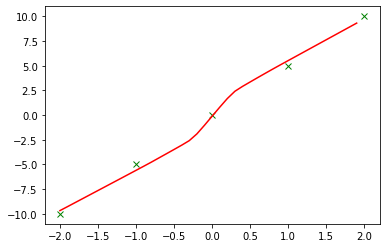

In [14]:
import numpy as np
import tensorflow as tf
import keras
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.optimizers import Adam

# One way of defining a model
#p_inputSpace = 4
#p_outputSpace = 2
#alpha = 0.001
#model=Sequential()
#model.add(Dense(24,input_shape=(p_inputSpace,), activation="relu"))
#model.add(Dense(24, activation="relu"))
#model.add(Dense(p_outputSpace, activation="linear"))
#model.compile(loss="mse", optimizer=Adam(lr=alpha))
#Dense = Fully Connected

# f : R^1 -> R^1
p_inputSpace = 1
p_outputSpace = 1

# define the model
inputs=keras.Input(shape=(p_inputSpace,),name="states")
x1 = keras.layers.Dense(64,activation="relu")(inputs)
x2 = keras.layers.Dense(64,activation="relu")(x1)
outputs = keras.layers.Dense(p_outputSpace, name="actions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

# plot it
tf.keras.utils.plot_model(
    model,
    #to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB", #TB: vertical; LR: hor
    expand_nested=True,
    dpi=96,
)

# optimizer and per-prediction error
alpha = 0.001
optimizer=tf.keras.optimizers.SGD(learning_rate=alpha)
f_ppError = keras.losses.MeanSquaredError()

# training data (plotted at the end of this file)
train = np.array([[-2,-10], [-1,-5], [0, 0], [1,5], [2,10]])
x_train = train[:,0]
y_train = train[:,1]
# for stochastic gradient descent, create batches
batch_size = 1
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

epochs = 40
for epoch in range(epochs):
  #print("\nStart of epoch %d" % (epoch,))
  for step, (x_batch_train,y_batch_train) in enumerate(train_dataset):
    #print(step,x_batch_train,y_batch_train)
    with tf.GradientTape() as tape:
      predictions = model(x_batch_train,training=True)
      ppError = f_ppError(y_batch_train,predictions)
    grads = tape.gradient(ppError,model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    print("Error: %f" % float(ppError))



D=np.arange(-2,2,.1)
R=model.predict(D)
from matplotlib import pyplot as plt
plt.plot(x_train,y_train,'gx',D,R,'r-')